### Обратная связь по проекту 
Шинкаренко Яна   
Telegram: [тык](https://t.me/sirena0789)

# Импорт библиотек

In [ ]:
%pip install vininfo
%pip install catboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import pickle
import bisect

from vininfo import Vin
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from catboost import Pool, CatBoostRegressor, CatBoostClassifier, cv
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# Знакомство с данными

## Вспомогательные функции

#### Функция для визуализации датасета

In [ ]:
def graph(df, color):
    cat_columns = df.drop(['model', 'trim', 'vin', 'saledate', 'seller'] ,axis=1).columns.to_list()
    numeric = df.select_dtypes(exclude='object').columns.to_list()
    f_size = (20, 80)
    plt.figure(figsize=f_size)
    for i, feature in enumerate(cat_columns):
        plt.subplot(9, 1, i+1)
        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        df[feature].hist(bins=100, color=color)
        plt.title(feature)
        plt.xticks(rotation=90)
        plt.xlabel("Значение признака")
        plt.ylabel("Количество")
    return

#### Функция вывода основных параметров датасета

In [ ]:
def hello(df, color):
    print('Пример строк \n')
    display(df.head(5))
    print('Размер фрейма:', df.shape)
    print('Количество дубликатов:', df.duplicated().sum())
    print('Количество пропусков:', df.isnull().sum().sum ())
    print('Корреляция признаков \n')
    display(df.describe())
    print('Визуализация признаков \n')
    graph(df, color)
    return

### train

In [ ]:
try:
    train = pd.read_csv("/Users/sirena0789/Desktop/Автомобили/data/train.csv")
except:
    train = pd.read_csv("/content/drive/MyDrive/car_cost/train.csv")

In [ ]:
hello(train.drop('sellingprice', axis=1), 'pink')

In [ ]:
train['sellingprice'].hist(bins=200, figsize=(18, 6), color='lightblue')
plt.title('sellingprice')

### test

In [ ]:
try:
    test = pd.read_csv("/Users/sirena0789/Desktop/Автомобили/data/test.csv")
except:
    test = pd.read_csv("/content/drive/MyDrive/car_cost/test.csv")

In [ ]:
hello(test, 'lightgray')

# Предобработка данных

## Вспомогательные функции

#### Функция для понижения регистра

In [ ]:
def reg_low(df):
    col_cat = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller']
    for i in col_cat:
        df[i] = df[i].str.lower()

#### Функция для удаления столбца с датой и добавления возраста машины и дня недели продажи

In [ ]:
def change_date(df):
    df['saledate'] = pd.to_datetime(df['saledate'], utc=True)
    df['saleyaer'] = pd.DatetimeIndex(df['saledate']).year
    df['weekday'] = df['saledate'].dt.weekday
    df['machineage'] =  df['saleyaer'] - df['year']
    df = df.drop(['saledate'], axis=1)
    return(df)

## Основная часть

#### Изменение формата даты и добавление новых признаков

In [ ]:
train = change_date(train)

test = change_date(test)

#### Изменение 141 строки с machineage = -1 на 0

In [ ]:
train.loc[train['machineage'] < 0, 'machineage'] = 0

#### Изменение 29 строк с machineage = -1

In [ ]:
test.loc[test['machineage'] < 0, 'machineage'] = 0

#### Удаление 1 строки с sellingprice = 1

In [ ]:
train = train[train['sellingprice'] >= 100]

#### Понижение регистра для удаления неявных дубликатов

In [ ]:
reg_low(train)

reg_low(test)

# Заполнение пропусков

## Вспомогательные функции

#### Функция для заполнения make с использованием vininfo

In [ ]:
def vin(df):
    df.loc[df['make'].isnull(), 'make'] = df.loc[df['make'].isnull()].apply(
        lambda row: Vin(row['vin']).manufacturer, axis=1)
    return (df)

#### Функция для заполнения мультиклассовых категориальных столбцов

In [ ]:
def filling_multiclass(df1, df2, column, columns, encoder_columns):

    name1 = df1.columns
    df_test1 = df1.loc[df1[column].isnull()]
    ind1 = df_test1.index

    name2 = df2.columns
    df_test2 = df2.loc[df2[column].isnull()]
    ind2 = df_test2.index

    df_train1 = df1.loc[df1[column].notna()]
    df_train2 = df2.loc[df2[column].notna()]


    df_target = df_train1[column]
    df_features = df_train1.drop(columns, axis=1)
    df_features = df_features.drop(['sellingprice'], axis=1)
    df_features = df_features.drop(column, axis=1)


    df_test1_new = df_test1.drop(column, axis=1)
    df_test2_new = df_test2.drop(column, axis=1)

    df_test1 = df_test1.drop(column, axis=1)
    df_test1 = df_test1.drop(columns, axis=1)
    df_test2 = df_test2.drop(column, axis=1)
    df_test2 = df_test2.drop(columns, axis=1)

    df_test1 = df_test1.drop(['sellingprice'], axis=1)

    le = LabelEncoder()

    for i in encoder_columns:
        df_features[i] = le.fit_transform(df_features[i])
        df_test1[i] = df_test1[i].map(lambda s: 'other' if s not in le.classes_ else s)
        df_test2[i] = df_test2[i].map(lambda s: 'other' if s not in le.classes_ else s)
        le_classes = le.classes_.tolist()
        bisect.insort_left(le_classes, 'other')
        le.classes_ = np.array(le_classes)
        df_test1[i] = le.transform(df_test1[i])
        df_test2[i] = le.transform(df_test2[i])

    features_train, features_valid, target_train, target_valid = train_test_split(
        df_features, df_target, test_size=0.25, random_state=1234)

    model = RandomForestClassifier(random_state=12345, criterion = 'entropy')

    model.fit(features_train, target_train)

    accuracy = accuracy_score(target_valid, model.predict(features_valid))
    target_predict1 = model.predict(df_test1)
    target_predict2 = model.predict(df_test2)

    target_predict1 = pd.Series(data=target_predict1, index=ind1)
    target_predict2 = pd.Series(data=target_predict2, index=ind2)

    df_test1_new[column] = target_predict1
    df_test2_new[column] = target_predict2

    df_test1_new = df_test1_new[name1]
    df_test2_new = df_test2_new[name2]

    df_new1 = pd.concat([df_train1, df_test1_new], axis=0)
    df_new2 = pd.concat([df_train2, df_test2_new], axis=0)
    return df_new1, df_new2, accuracy

#### Функция для заполнения бинарных категориальных столбцов

In [ ]:
def filling_binary(df1, df2, column, columns):

    name1 = df1.columns
    df_test1 = df1.loc[df1[column].isnull()]
    ind1 = df_test1.index

    name2 = df2.columns
    df_test2 = df2.loc[df2[column].isnull()]
    ind2 = df_test2.index

    df_train1 = df1.loc[df1[column].notna()]
    df_train2 = df2.loc[df2[column].notna()]


    df_target = df_train1[column]
    df_features = df_train1.drop(columns, axis=1)
    df_features = df_features.drop(['sellingprice'], axis=1)
    df_features = df_features.drop(column, axis=1)


    df_test1_new = df_test1.drop(column, axis=1)
    df_test2_new = df_test2.drop(column, axis=1)

    df_test1 = df_test1.drop(column, axis=1)
    df_test1 = df_test1.drop(columns, axis=1)
    df_test2 = df_test2.drop(column, axis=1)
    df_test2 = df_test2.drop(columns, axis=1)

    df_test1 = df_test1.drop(['sellingprice'], axis=1)

    features_train, features_valid, target_train, target_valid = train_test_split(
        df_features, df_target, test_size=0.25, random_state=1234)

    model = CatBoostClassifier(learning_rate=0.2, random_state=1234, verbose=False, task_type="GPU",
                          cat_features=["make","model","trim",
                                        "body","state","color", "interior", "seller"])

    model.fit(features_train, target_train)

    accuracy = accuracy_score(target_valid, model.predict(features_valid))
    target_predict1 = model.predict(df_test1)
    target_predict2 = model.predict(df_test2)

    target_predict1 = pd.Series(data=target_predict1, index=ind1)
    target_predict2 = pd.Series(data=target_predict2, index=ind2)

    df_test1_new[column] = target_predict1
    df_test2_new[column] = target_predict2

    df_test1_new = df_test1_new[name1]
    df_test2_new = df_test2_new[name2]

    df_new1 = pd.concat([df_train1, df_test1_new], axis=0)
    df_new2 = pd.concat([df_train2, df_test2_new], axis=0)
    return df_new1, df_new2, accuracy

#### Функция для заполнения численных столбцов

In [ ]:
def filling_regressor(df1, df2, column, columns):

    name1 = df1.columns
    df_test1 = df1.loc[df1[column].isnull()]
    ind1 = df_test1.index

    name2 = df2.columns
    df_test2 = df2.loc[df2[column].isnull()]
    ind2 = df_test2.index

    df_train1 = df1.loc[df1[column].notna()]
    df_train2 = df2.loc[df2[column].notna()]


    df_target = df_train1[column]
    df_features = df_train1.drop(columns, axis=1)
    df_features = df_features.drop(['sellingprice'], axis=1)
    df_features = df_features.drop(column, axis=1)


    df_test1_new = df_test1.drop(column, axis=1)
    df_test2_new = df_test2.drop(column, axis=1)

    df_test1 = df_test1.drop(column, axis=1)
    df_test1 = df_test1.drop(columns, axis=1)
    df_test2 = df_test2.drop(column, axis=1)
    df_test2 = df_test2.drop(columns, axis=1)

    df_test1 = df_test1.drop(['sellingprice'], axis=1)

    features_train, features_valid, target_train, target_valid = train_test_split(
        df_features, df_target, test_size=0.25, random_state=1234)

    model = CatBoostRegressor(random_state=12345, task_type="GPU", eval_metric="RMSE",
                              cat_features=['make', 'model', 'trim', 'body',
                                            'state','color','interior', 'seller', 'transmission'],
                              learning_rate=0.2, verbose= False)

    model.fit(features_train, target_train)

    MSE = mean_squared_error(target_valid, model.predict(features_valid))
    target_predict1 = model.predict(df_test1)
    target_predict2 = model.predict(df_test2)

    target_predict1 = pd.Series(data=target_predict1, index=ind1)
    target_predict2 = pd.Series(data=target_predict2, index=ind2)

    df_test1_new[column] = target_predict1
    df_test2_new[column] = target_predict2

    df_test1_new = df_test1_new[name1]
    df_test2_new = df_test2_new[name2]

    df_new1 = pd.concat([df_train1, df_test1_new], axis=0)
    df_new2 = pd.concat([df_train2, df_test2_new], axis=0)
    return df_new1, df_new2, MSE

## Основная часть

#### Заполнение пропусков в 'color', 'interior'

In [ ]:
train['color'] = train['color'].fillna('-')
train['interior'] = train['interior'].fillna('-')

test['color'] = test['color'].fillna('-')
test['interior'] = test['interior'].fillna('-')

#### Заполнение пропусков в 'make'

In [ ]:
train = vin(train)

test = vin(test)

#### Удаление вин

In [ ]:
train = train.drop(['vin'], axis=1)

#### Сохранение индексов и вина из теста для итогового файла

In [ ]:
ind = test.index
vin_test = test['vin']
vin_test = pd.DataFrame(data=vin_test, index=ind)
test = test.drop(['vin'], axis=1)

#### Повторное понижение регистра после заполнения'make'

In [ ]:
reg_low(train)
reg_low(test)

#### Заполнение 'model'

In [ ]:
column = 'model'
columns = ['trim','body','transmission','condition' ,
           'odometer', 'saleyaer', 'weekday']
encoder_columns = ['make', 'state','color', 'interior', 'seller']

train, test, acc = filling_multiclass(train, test, column, columns, encoder_columns)

#### Заполнение 'trim'

In [ ]:
column = 'trim'
columns = ['body','transmission','condition' ,
           'odometer', 'saleyaer', 'weekday']
encoder_columns = ['make', 'model', 'state','color', 'interior', 'seller']

train, test, acc = filling_multiclass(train, test, column, columns, encoder_columns)

#### Заполнение 'body'

In [ ]:
column = 'body'
columns = ['transmission','condition' ,
           'odometer', 'saleyaer', 'weekday']
encoder_columns = ['make', 'model', 'trim', 'state','color', 'interior', 'seller']

train, test, acc = filling_multiclass(train, test, column, columns, encoder_columns)

#### Заполнение 'transmission'

In [ ]:
column = 'transmission'
columns = ['condition' , 'odometer', 'saleyaer', 'weekday']

train, test, acc = filling_binary(train, test, column, columns)

#### Заполнение 'condition'

In [ ]:
column = 'condition'
columns = ['odometer', 'saleyaer', 'weekday']

train, test, MSE = filling_regressor(train, test, column, columns)

#### Заполнение 'odometer'

In [ ]:
column = 'odometer'
columns = ['saleyaer', 'weekday']

train, test, MSE = filling_regressor(train, test, column, columns)

### Сохранение заполненых фреймов в файл

In [ ]:
try:
    train.to_csv("/Users/sirena0789/Desktop/Автомобили/data/train_notnull.csv")
    test.to_csv("/Users/sirena0789/Desktop/Автомобили/data/test_notnul.csv")
except:
    test.to_csv('/content/drive/MyDrive/car_cost/test_notnull.csv')
    train.to_csv('/content/drive/MyDrive/car_cost/train_notnull.csv')

### Изьятие заполненых фреймов из файла (опционально)

In [3]:
try:
    train = pd.read_csv("/Users/sirena0789/Desktop/Автомобили/data/train_notnull.csv", index_col=0)
    test = pd.read_csv("/Users/sirena0789/Desktop/Автомобили/data/test_notnull.csv", index_col=0)
except:
    train = pd.read_csv("/content/drive/MyDrive/car_cost/train_notnull.csv", index_col=0)
    test = pd.read_csv("/content/drive/MyDrive/car_cost/test_notnull.csv", index_col=0)

# Работа с выборками

## Вспомогательные функции

### Функция для LabelEncoder()

In [4]:
def LE(df_features, df_test, cat_columns):
    le = LabelEncoder()
    for i in cat_columns:
        df_features[i] = le.fit_transform(df_features[i])
        df_test[i] = df_test[i].map(lambda s: 'other' if s not in le.classes_ else s)
        le_classes = le.classes_.tolist()
        bisect.insort_left(le_classes, 'other')
        le.classes_ = np.array(le_classes)
        df_test[i] = le.transform(df_test[i])
    return df_features, df_test

### Функция для StandardScaler()

In [5]:
def scaler(features_train,features_test, columns):
    scaler = StandardScaler()

    scaler.fit(features_train[columns])

    features_train = features_train.copy()
    features_train[columns] = scaler.transform(features_train[columns])

    features_test = features_test.copy()
    features_test[columns] = scaler.transform(features_test[columns])
    return features_train, features_test

### Функция для OHE()

In [ ]:
def OHE(df1, df2):
    
    cat_columns = df1.select_dtypes(include='object').columns.to_list()

    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(df1[cat_columns]).toarray())
    df1_enc = df1.join(encoder_df)
    df1 = df1_enc.drop(cat_columns, axis=1)
    
    encoder_df = pd.DataFrame(encoder.transform(df2[cat_columns]).toarray())
    df2_enc = df2.join(encoder_df)
    df2 = df2_enc.drop(cat_columns, axis=1)
    
    return df1, df2

## Основная часть

### Составление трех пар выборок для тестирования

In [6]:
features_original = train.drop('sellingprice', axis=1)
test_original = test.copy()

features_le = train.drop('sellingprice', axis=1)
test_le = test.copy()

features_ohe = train.drop('sellingprice', axis=1)
test_ohe = test.copy()

target = train['sellingprice']

### Выявление котегориальных и численных столбцов

In [7]:
cat_columns = features_original.select_dtypes(include='object').columns.to_list()
numeric = features_original.select_dtypes(exclude='object').columns.to_list()

### Обработка  выборки с помощью StandardScaler

In [25]:
features_original, test_original = scaler(features_original, test_original, numeric)

### Обработка  выборки с помощью LabelEncoder

In [8]:
features_le, test_le = scaler(features_le, test_le, numeric)
features_le, test_le = LE(features_le, test_le, cat_columns)

### Обработка  выборки с помощью OHE

In [ ]:
features_ohe, test_ohe = scaler(features_ohe, test_ohe, numeric)
features_ohe, test_ohe = OHE(features_ohe, test_ohe)

### Деление выборки на обучающую и валидационную

In [27]:
features_original_train, features_original_valid, target_original_train, target_original_valid = train_test_split(
    features_original, target, test_size=0.25, random_state=1234)

In [9]:
features_le_train, features_le_valid, target_le_train, target_le_valid = train_test_split(
    features_le, target, test_size=0.25, random_state=1234)

In [ ]:
features_ohe_train, features_ohe_valid, target_ohe_train, target_ohe_valid = train_test_split(
    features_ohe, target, test_size=0.25, random_state=1234)

# Обучение моделей

### Функция для вычисления mape

In [10]:
def mape(test, pred):
    test, pred = np.array(test), np.array(pred)
    mape = np.mean(np.abs((test - pred) / test))
    return mape

## CatBoost

### Оригинальная выборка

In [28]:
%%time

model = CatBoostRegressor(cat_features=['make', 'model', 'trim', 'body',
                                 'transmission', 'state','color',
                                 'interior', 'seller']) #, task_type='GPU'

params = [{'learning_rate':[0.01, 0.03],
           'iterations':[1000, 3000],
           'random_state':[1234],
           'verbose':[False]}]

cbr_or = GridSearchCV(estimator = model, param_grid = params, cv = 2,
                   n_jobs = -1, scoring='neg_mean_absolute_percentage_error', 
                      error_score='raise')

cbr_or.fit(features_original_train, target_original_train)

pred = cbr_or.predict(features_original_valid)
MAPE_CBR_original = mape(target_original_valid, pred)
print("MAPE:", MAPE_CBR_original)

print("Best parameters:")
print(cbr_or.best_params_)

MAPE: 0.1791468396640985
Best parameters:
{'iterations': 3000, 'learning_rate': 0.03, 'random_state': 1234, 'verbose': False}
CPU times: user 21min 55s, sys: 25.9 s, total: 22min 21s
Wall time: 13min 33s


### LabelEncoder выборка

In [30]:
%%time

model = CatBoostRegressor(random_state=1234) #, task_type='GPU'

params = [{'learning_rate':[0.01, 0.03],
           'iterations':[1000, 3000],
           'random_state':[1234],
           'verbose':[False]}]

cbr_le = GridSearchCV(estimator = model, param_grid = params, cv = 2,
                   n_jobs = -1, scoring='neg_mean_absolute_percentage_error',
                      error_score='raise')

cbr_le.fit(features_le_train, target_le_train)

pred = cbr_le.predict(features_le_valid)
MAPE_CBR_LE = mape(target_le_valid, pred)
print("MAPE:", MAPE_CBR_LE)

print("Best parameters:")
print(cbr_le.best_params_)

MAPE: 0.20897658475374445
Best parameters:
{'iterations': 3000, 'learning_rate': 0.03, 'random_state': 1234, 'verbose': False}
CPU times: user 2min 25s, sys: 10.8 s, total: 2min 36s
Wall time: 1min 25s


### OHE выборка

In [ ]:
%%time

model = CatBoostRegressor() #, task_type='GPU'

params = [{'learning_rate':[0.01, 0.03],
           'iterations':[1000, 3000],
          'random_state':[1234],
          'verbose':[False]}]

cbr_ohe = GridSearchCV(estimator = model, param_grid = params, cv = 2,
                   n_jobs = -1, scoring='neg_mean_absolute_percentage_error', 
                       error_score='raise')

cbr_ohe.fit(features_ohe_train, target_ohe_train)

pred = cbr_ohe.predict(features_ohe_valid)
MAPE_CBR_OHE = mape(target_ohe_valid, pred)
print("Best parameters:")
print(clf.best_params_)
print("MAPE:", MAPE_CBR_OHE)

## DecisionTreeRegressor

### LabelEncoder выборка

In [21]:
%%time

model = DecisionTreeRegressor()

params = [{'max_depth': range(1, 30, 2),
          'random_state':[1234]}]

dtr = GridSearchCV(estimator = model, param_grid = params, cv = 2, 
                       scoring='neg_mean_absolute_percentage_error', error_score='raise')

dtr.fit(features_le_train, target_le_train)

pred = dtr.predict(features_le_valid)
MAPE_DTR_le = mape(target_le_valid, pred)
print("MAPE:", MAPE_DTR_le)

print("Best parameters:")
print(dtr.best_params_)

MAPE: 0.23331688830163927
Best parameters:
{'max_depth': 19, 'random_state': 1234}
CPU times: user 24 s, sys: 222 ms, total: 24.2 s
Wall time: 24.2 s


### OHE выборка

In [ ]:
%%time


model = DecisionTreeRegressor()

params = [{'max_depth': range(1, 30, 2),
          'random_state':[1234]}]

dtr = GridSearchCV(estimator = model, param_grid = params, cv = 2, 
                       scoring='neg_mean_absolute_percentage_error', error_score='raise')

dtr.fit(features_le_train, target_le_train)

pred = dtr.predict(features_ohe_valid)
MAPE_DTR_ohe = mape(target_ohe_valid, pred)
print("Best parameters:")
print(dtr.best_params_)
print("MAPE:", MAPE_DTR_ohe)

### Сводная таблица

In [32]:
index = ['CatBoostRegression + StandardScaler',
         'CatBoostRegression + StandardScaler + LabelEncoder',
         'CatBoostRegression + StandardScaler + OHE',
         'DecisionTreeRegressor + StandardScaler + LabelEncoder',
         'DecisionTreeRegressor + StandardScaler + OHE']
data = {'MAPE на валидационной выборке':[MAPE_CBR_original, MAPE_CBR_LE, '-', MAPE_DTR_le, '-'], 
       'Время обучения с GS':['13min 2s', '1min 27s', '-', '24.2 s', '-']}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,MAPE на валидационной выборке,Время обучения с GS
CatBoostRegression + StandardScaler,0.179147,13min 2s
CatBoostRegression + StandardScaler + LabelEncoder,0.208977,1min 27s
CatBoostRegression + StandardScaler + OHE,-,-
DecisionTreeRegressor + StandardScaler + LabelEncoder,0.233317,24.2 s
DecisionTreeRegressor + StandardScaler + OHE,-,-


# Финальная модель

In [33]:
pred = cbr_or.predict(features_original_valid)

MAPE_CBR = mape(target_original_valid, pred)
print("MAPE на валидационной выборке:", MAPE_CBR)

predict = cbr_or.predict(test_original)

MAPE на валидационной выборке: 0.1791468396640985


## Важность признаков

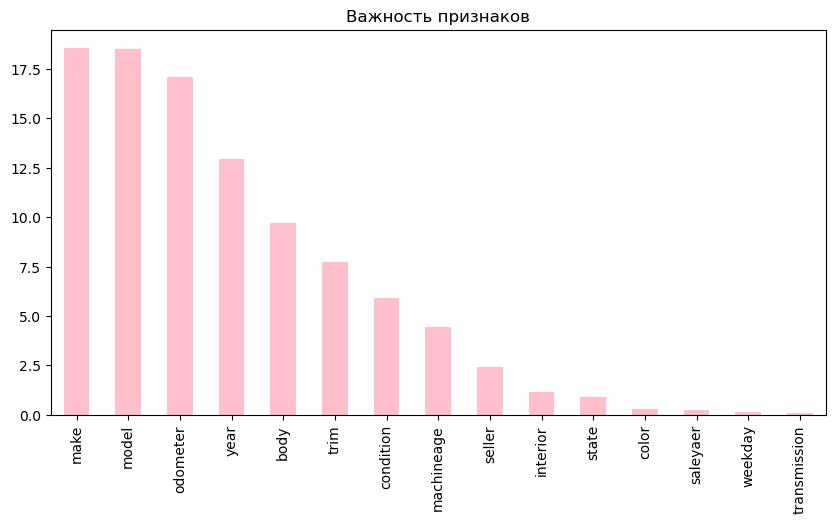

In [39]:
im_df = pd.DataFrame(cbr_or.best_estimator_.feature_importances_,
                     index = features_original_train.columns, columns=['import'])
im_df = im_df.sort_values(by='import', ascending=False)
im_df.plot(kind='bar', figsize=(10, 5), title='Важность признаков', color='pink', legend=False)
plt.show()

## Сбор итогового файла

In [ ]:
test_original = test_original.merge(vin_test, left_index = True, right_index = True)
test_original = test_original.reset_index()
test_original['sellingprice'] = predict[0]
col = ['vin', 'sellingprice']
submission = test_original[col]
try:
    submission.to_csv("/Users/sirena0789/Desktop/Автомобили/data/submission.csv", index=False)
except:
    submission.to_csv("/content/drive/MyDrive/car_cost/submission.csv", index=False)

## Комментарий для ревью

В данном проекте я постаралась реализовать идею заполнения пропусков в данных с помощью машинного обучения. На это ушло много времени и ресурсов, но по заполнению категориальных столбцов accuracy варьировался в пределах 35-95% в зависимости от типа заполняемого столбца, а MSE по численным столбцам получалась в районе 44-50%.  
Данные результаты говорят о том, что пропущенные значения спрогнозированны не совсем корректно, но любые действия направленные на улучшение метрики (подбор гиперпараметров, использование других моделей) сильно увеличиваает время работы программы, поэтому я старалась балансировать между качеством и скоростью выполнения.  
**Совет для ревьюера:** не запускай локально модели заполнения пропусков, а лучше воспользуйся уже заполненным датасетом из прикрепленных файлов. Заполнение пропусков требует больших обьемов оперативки и времени. Скорее всего все ляжет.

По этой же причине мне не удалось сделать кодировку с помощью OHE. В коде прописанна функция для этого, но ее запуск убивает ядро мгновенно из за большого обьема данных. Лег даже V100 с 52 гб оперативки. Так же я пробовала кодировать сет частями, но это также не привело к хорошим результатам. Больше ничего придумать не смогла.

Мною были протестированы 2 модели. CatBoost на стандартизированной выборке и кодировкой внутри самой модели, CatBoost на закодированной
LabelEncoder выборке и DecisionTreeRegressor на закодированной LabelEncoder выборке со следующими результатами:

| Model | MAPE |
| ------ | ------ |
| CatBoostRegression + StandardScaler| 0.179147 |
| CatBoostRegression + StandardScaler + LabelEncoder | 0.208977 |
| DecisionTreeRegressor + StandardScaler + LabelEncoder	 | 0.233317 |


К сожалению, выборку с OHE по причине выше проверить не удалось. 
Плюс есть еще нюанс: MAPE на валидационной выборке составляет порядка 17-21%, а на тестовой я получаю 200%. Причину я так и не выяснила. Вероятно, где то произошла неполадка с индексами, из за чего в итоговой таблице все перемешалось. Или все таки причина в неверной кодировке. Я пробовала загружать файлы с предсказаниями разных моделей, но MAPE на Kaggle всегда примерно один и тот же.

Если честно, то меня уже тошнит от этого проекта. Слишком много времени и сил я на него потратила и не добилась даже сносных результатов.
Уже нет желания, сидеть над ним дальше, поэтому сдаю проект в таком недоработанном формате с отвратительной метрикой. Возможно, что позже я к нему вернусь с новыми идеями и доработаю. Было бы здорово получить файл с тестовым таргетом для проверок будущих идей.

Прошу понять и простить🫣

## Варианты улучшения проекта
- Проверить метриику выборки с кодировкой OHE 
- Улучшить показатели моделей для заполнения пропусков путем подбора гиперпараметров или путем изменения метода масштабирования данных
- Удалить пропуски в трейне и тесте 
- Оптимизировать получение информации из vin (есть сайты, где по запросу можно получить практически все нужные нам данные)
- Проработать мультиколлениарность признаков и удалить лишние
- Обновить фрейм с учетом данных о важности признаков для обучения